In [2]:
import json
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import collections
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import normalize

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
df = pd.read_csv('pet_supplies.csv', thousands=',')
df = df.sample(n=50000)

In [4]:
overall = df['overall']
overall.describe()

count    50000.000000
mean         4.265100
std          1.214797
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

Text(0, 0.5, 'Counts')

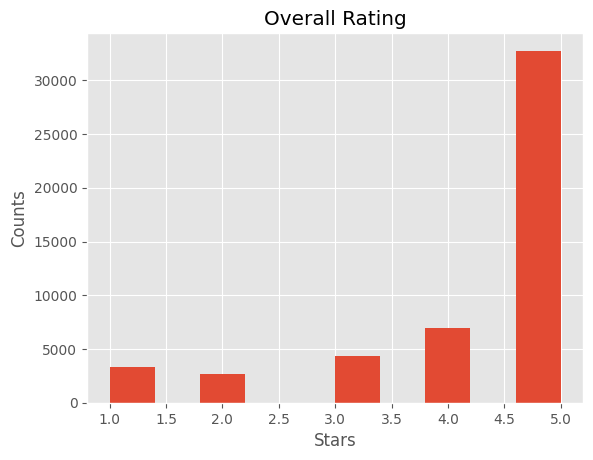

In [5]:
plt.hist(overall, density = False)
plt.title('Overall Rating')
plt.xlabel('Stars')
plt.ylabel('Counts')

The initial impression is that most user just leave 5 star reviews, nearly 70% of the data. And it's pretty rare to see 1s and 2s. 

(array([3.89371710e-13, 1.55748684e-12, 1.20705230e-11, 4.75033486e-11,
        1.16811513e-10, 3.99884746e-10, 1.61277762e-09, 4.75967978e-09,
        7.60014640e-09, 4.91776469e-09]),
 array([1.0244448e+09, 1.0758096e+09, 1.1271744e+09, 1.1785392e+09,
        1.2299040e+09, 1.2812688e+09, 1.3326336e+09, 1.3839984e+09,
        1.4353632e+09, 1.4867280e+09, 1.5380928e+09]),
 <BarContainer object of 10 artists>)

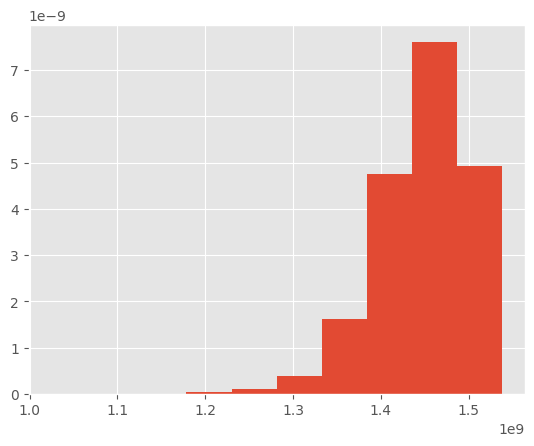

In [6]:
unix_time = df['unixReviewTime']
plt.hist(unix_time, density = True)

Most reviews are written in the evening

In [7]:
df.isnull().values.any()

True

Replace NaN vote values with 0 because 0 vote seem to be NaN.

In [8]:
df['vote'].fillna(0, inplace=True)

In [9]:
max(df.groupby(['asin'])['asin'].count())

334

In [10]:
group_asin = df.groupby(['asin']).count().sort_values(by=['overall'], ascending=False)
group_asin

,overall,vote,verified,reviewTime,reviewerID,reviewerName,reviewText,summary,unixReviewTime,style,image
asin,,,,,,,,,,,
B0012NV9NQ,334,334,334,334,334,334,334,334,334,330,21
B000W5QSYA,322,322,322,322,322,322,321,322,322,320,5
B0013MVJPY,279,279,279,279,279,279,279,279,279,0,10
B0009YD8OC,159,159,159,159,159,159,159,159,159,0,0
B001A5IXRG,149,149,149,149,149,149,148,149,149,0,6
...,...,...,...,...,...,...,...,...,...,...,...
B006JLJPSM,1,1,1,1,1,1,1,1,1,0,0
B006JT42LY,1,1,1,1,1,1,1,1,1,1,0
B006JVPUUY,1,1,1,1,1,1,1,1,1,0,0


In [11]:
df.isna().sum()

overall               0
vote                  0
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName          4
reviewText           17
summary              15
unixReviewTime        0
style             15976
image             48416
dtype: int64

In [12]:
!pip install wordcloud==1.8.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 KB 53.4 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

Word cloud of reviewText

In [14]:
texts = df['reviewText'].dropna()
texts

470235     This toy has lasted longer than any other that...
1319638                                                 Nice
77081      Wow! Crystal Clear.\nThis stuff really works! ...
1423172    I am being generous giving this product 2 star...
752408                           love it! received promptly!
                                 ...                        
487811     Very nice looking wood.  It has the same tanni...
1425856    Couldn't get the battery cover unscrewed to ge...
1237580    I've been buying Milk Bone snacks for my dogs ...
648046     Roudybush is not the best pellet, but is ok if...
1005220    Although the product is effective and reasonab...
Name: reviewText, Length: 49983, dtype: object

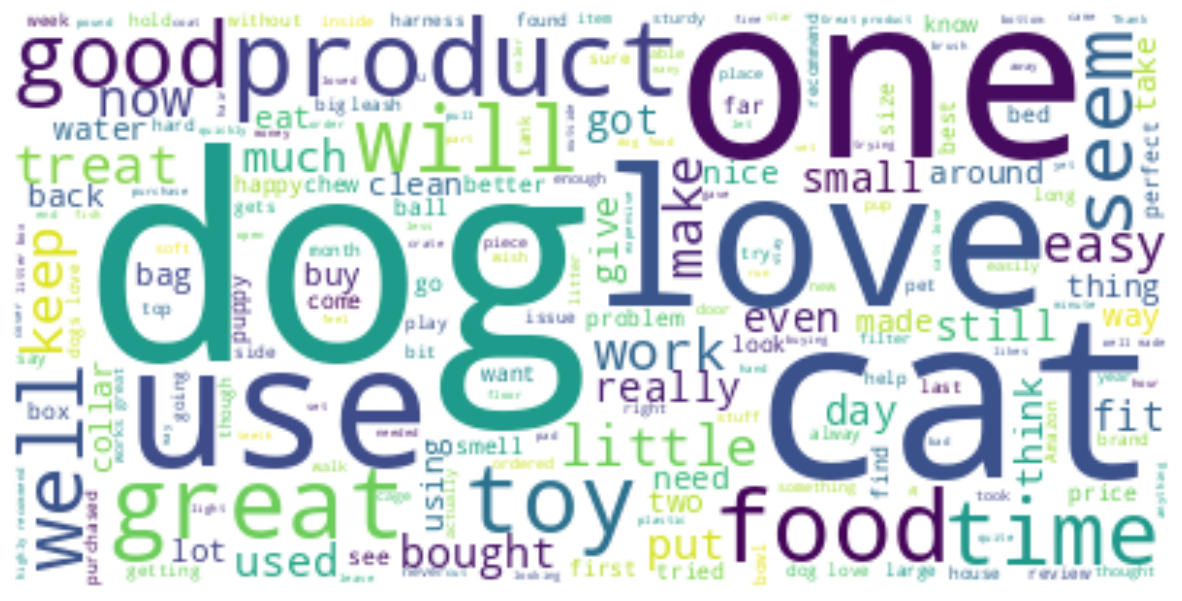

In [15]:
text = " ".join(i for i in texts)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud of smmaries

In [16]:
summaries = df['summary'].dropna()
summaries

470235                         Great toy for my Mal to chew!
1319638                                                 Nice
77081                Seachem have the best aquarium products
1423172    Bottle too little, Smell too bad, Efficacy too...
752408                                            Five Stars
                                 ...                        
487811                                   Good piece of wood!
1425856    Couldn't get the battery cover unscrewed to ge...
1237580                                                Great
648046                                           3 Star Food
1005220                      too short effective time period
Name: summary, Length: 49985, dtype: object

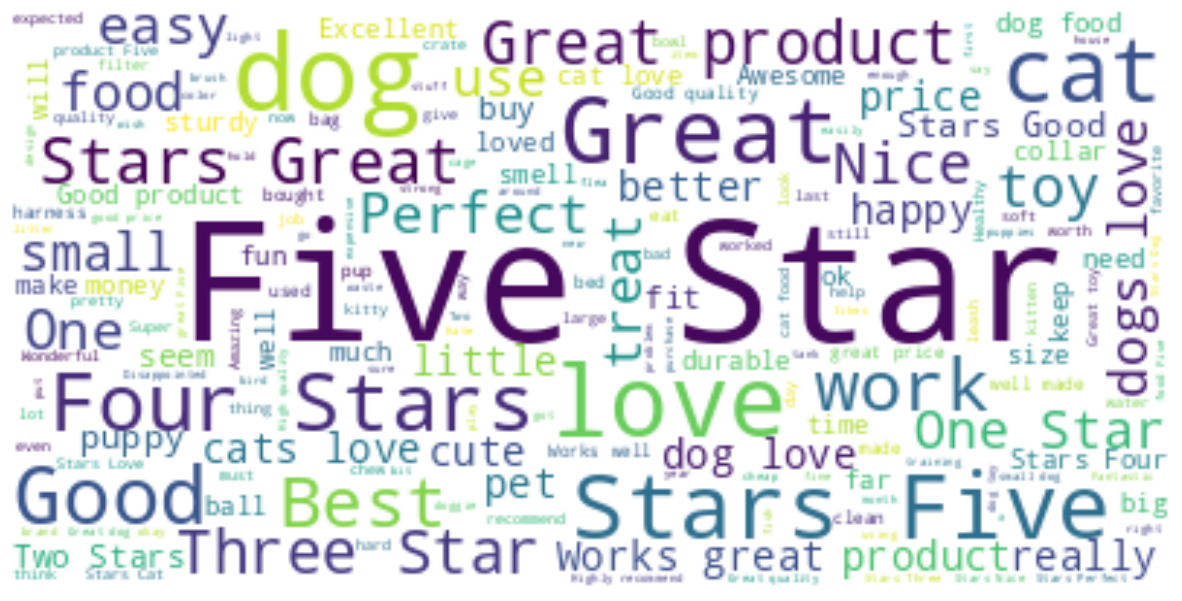

In [17]:
text = " ".join(i for i in summaries)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
dog = df['reviewText'].str.contains('dog').replace({True: 1, False: 0})


In [19]:
cat = df['reviewText'].str.contains('cat').replace({True: 1, False: 0})


In [20]:
fish = df['reviewText'].str.contains('fish').replace({True: 1, False: 0})


In [21]:
bird = df['reviewText'].str.contains('bird').replace({True: 1, False: 0})


In [22]:
chicken = df['reviewText'].str.contains('chicken').replace({True: 1, False: 0})


In [23]:
good = df['reviewText'].str.contains('good').replace({True: 1, False: 0})


In [24]:
great = df['reviewText'].str.contains('great').replace({True: 1, False: 0})


In [25]:
best = df['reviewText'].str.contains('best').replace({True: 1, False: 0})

In [26]:
love = df['reviewText'].str.contains('love').replace({True: 1, False: 0})

In [27]:
excellent = df['reviewText'].str.contains('excellent').replace({True: 1, False: 0})


In [28]:
bad = df['reviewText'].str.contains('bad').replace({True: 1, False: 0})


In [29]:
terrible = df['reviewText'].str.contains('terrible').replace({True: 1, False: 0})


In [30]:
disappointed = df['reviewText'].str.contains('disappointed').replace({True: 1, False: 0})


In [31]:
one_star = df['reviewText'].str.contains('one star').replace({True: 1, False: 0})

In [32]:
five_star = df['reviewText'].str.contains('five star').replace({True: 1, False: 0})

In [33]:
returned = df['reviewText'].str.contains('returned').replace({True: 1, False: 0})

In [34]:
food = df['reviewText'].str.contains('food').replace({True: 1, False: 0})

In [35]:
toy = df['reviewText'].str.contains('toy').replace({True: 1, False: 0})

In [36]:
features = pd.DataFrame({
                         'dog': dog,
                         'cat': cat,    
                         'bird': bird,
                         'fish': fish,
                         'chicken': chicken,
                         'good': good,
                         'great': great,
                         'best': best,
                         'love': love,
                         'excellent': excellent,
                         'bad': bad,
                         'terrible': terrible,
                         'disappointed': disappointed,
                         'one_star': one_star,
                         'five_star': five_star,
                         'returned': returned,
                         'food': food,
                         'toy': toy
                        })
features

,dog,cat,bird,fish,chicken,good,great,best,love,excellent,bad,terrible,disappointed,one_star,five_star,returned,food,toy
470235,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1319638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1423172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1425856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1237580,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648046,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
verified = df['verified'].replace({True: 1, False: 0})
verified

470235     1
1319638    1
77081      1
1423172    1
752408     1
          ..
487811     1
1425856    1
1237580    1
648046     1
1005220    1
Name: verified, Length: 50000, dtype: int64

Take the natural log of unixReviewTime to rescale time

In [38]:
logreview_time = np.log(df['unixReviewTime'])
logreview_time

470235     21.038172
1319638    21.114629
77081      21.062899
1423172    21.060928
752408     21.103999
             ...    
487811     21.127514
1425856    21.062714
1237580    21.035331
648046     21.126649
1005220    21.017529
Name: unixReviewTime, Length: 50000, dtype: float64

In [39]:
features = features.join(df['overall'])
features = features.join(df['vote'])
features = features.join(verified)
features = features.join(logreview_time)

Normalize the data via sklearn

In [40]:
features = features.dropna()
#features = features[features.vote != '1,044']
#features = features[features.vote != '1,304']
#features = features[features.vote != '1,237']
#features = features[features.vote != '1,081']
#features = features[features.vote != '1,011']
features["vote"] = features["vote"].astype(float)
normalized = normalize(features, axis=0)

In [41]:
features.isna().sum()

dog               0
cat               0
bird              0
fish              0
chicken           0
good              0
great             0
best              0
love              0
excellent         0
bad               0
terrible          0
disappointed      0
one_star          0
five_star         0
returned          0
food              0
toy               0
overall           0
vote              0
verified          0
unixReviewTime    0
dtype: int64

In [42]:
nor_df = pd.DataFrame(normalized, columns = features.columns)
nor_df

,dog,cat,bird,fish,chicken,good,great,best,love,excellent,...,disappointed,one_star,five_star,returned,food,toy,overall,vote,verified,unixReviewTime
0,0.007864,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.016819,0.004027,0.000000,0.004662,0.004461
1,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.004027,0.000000,0.004662,0.004477
2,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.024478,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.005034,0.000000,0.004662,0.004466
3,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.002014,0.000000,0.004662,0.004466
4,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.008924,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.005034,0.000000,0.004662,0.004475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49978,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.024478,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.005034,0.000916,0.004662,0.004480
49979,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.064018,0.0,0.000000,0.001007,0.000611,0.004662,0.004466
49980,0.007864,0.000000,0.000000,0.0,0.0,0.00000,0.011978,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.005034,0.000000,0.004662,0.004461
49981,0.000000,0.010512,0.042914,0.0,0.0,0.01331,0.000000,0.024478,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.003020,0.000000,0.004662,0.004480


Finding the optimal K that yields the best silhouette score for clustering

In [43]:
X = nor_df.to_numpy()

In [86]:
k_choices = range(2, 10) #2~8
best_k = 2
best_score = -1  #lowest score to begin with
#X = nor_df.to_numpy()

for k in k_choices:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    if score > best_score:
        best_score = score
        best_k = k

best_k 

KeyboardInterrupt: 

Finding the optimal K using Distortion via the "sum of squared errors" metric

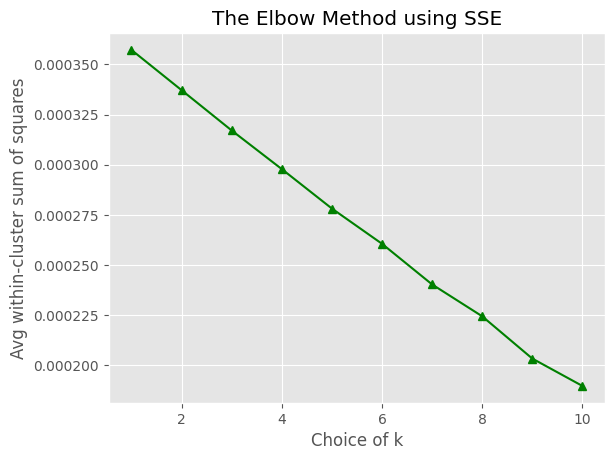

In [87]:
k_s = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
var = []
for k in k_s:
  kmean = KMeans(n_clusters=k, random_state=42)
  kmean.fit(X)
  var.append(kmean.inertia_ / len(X)) #divide numRows to get avg from intertia(Sum of squared errors)

plt.plot(k_s, var, 'g^-')
plt.xlabel('Choice of k')
plt.ylabel('Avg within-cluster sum of squares')
plt.title('The Elbow Method using SSE')
plt.show()

Finding the optimal K using Distortion via the Elbow Method

In [88]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [89]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.013668036732975895
2 : 0.01333729181396381
3 : 0.012892550527192436
4 : 0.012942696863780169
5 : 0.012259178438143309
6 : 0.012128382249589387
7 : 0.011803131703858473
8 : 0.01098894623199078
9 : 0.010651483815354523


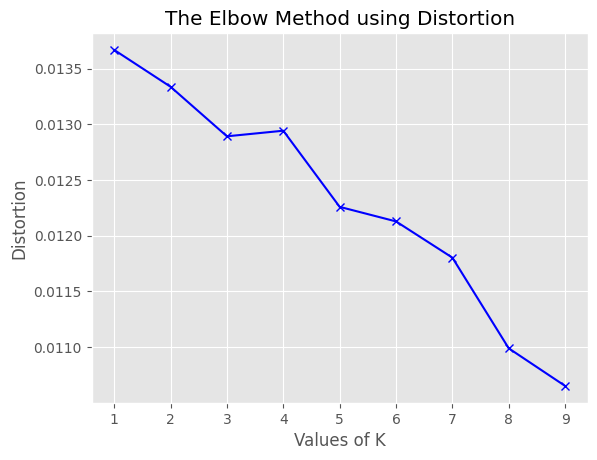

In [90]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Finding the optimal K using Inertia via the Elbow Method

In [91]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 17.856483696987574
2 : 16.843515850211197
3 : 15.865136862605196
4 : 14.867084180446472
5 : 14.032520334072812
6 : 12.965845801520917
7 : 12.090967616234085
8 : 11.258543147398177
9 : 10.325294262754257


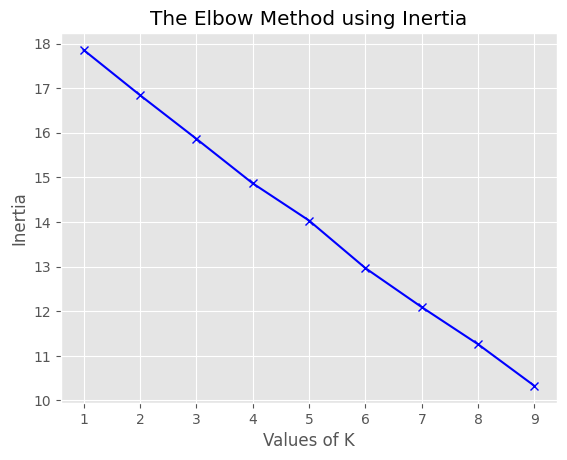

In [92]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Based on the above graphs, K=7 or K=8 seem to yield the best result

See the number of data points in each cluster when K = 7

In [93]:
X = nor_df.to_numpy()

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True) # get the cluster labels and the # of data points in each cluster
dict(zip(unique, counts))

{0: 47602, 1: 237, 2: 498, 3: 83, 4: 503, 5: 77, 6: 986}

See the number of data points in each cluster when K = 8

In [94]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True) # get the cluster labels and the # of data points in each cluster
dict(zip(unique, counts))

{0: 41101, 1: 6491, 2: 234, 3: 968, 4: 77, 5: 423, 6: 533, 7: 159}

Most reviews are classified into cluster 0 when K=7 and when K=8

Find the average feature values in each of the clusters:

In [95]:
nor_df['cluster_id'] = labels
groupby_id = nor_df.groupby(['cluster_id']).mean()
groupby_id.idxmax(axis=0)

dog               7
cat               4
bird              6
fish              4
chicken           4
good              4
great             1
best              4
love              6
excellent         5
bad               3
terrible          7
disappointed      5
one_star          4
five_star         4
returned          2
food              7
toy               6
overall           1
vote              2
verified          0
unixReviewTime    0
dtype: int64

Cluster 1 has the highest average overall/stars. Cluster 3 contains the most 'bad' word in review. Cluster 7 is most likely for dog supplies, and Cluster 2 has the most votes on average. Cluster 4 is most likely for cat supplies. Cluster 6 is most likely for toys

Apply PCA for visualization

In [44]:
from sklearn.decomposition import PCA

pca = PCA(2)
X_pca = pca.fit_transform(X)

X_pca.shape

(49983, 2)

In [45]:
X_pca

array([[-0.00283647,  0.00502691],
       [-0.00336817, -0.0009762 ],
       [ 0.00307768,  0.00278963],
       ...,
       [-0.00154202,  0.0007522 ],
       [ 0.01253528,  0.00798605],
       [-0.00336539, -0.00091491]])

In [46]:
#Initialize the class object
kmeans = KMeans(n_clusters= 8)
 
#predict the labels of clusters.
label = kmeans.fit_predict(X_pca)
 
print(label)

[7 0 7 ... 0 1 0]


Visualize out a particular cluster

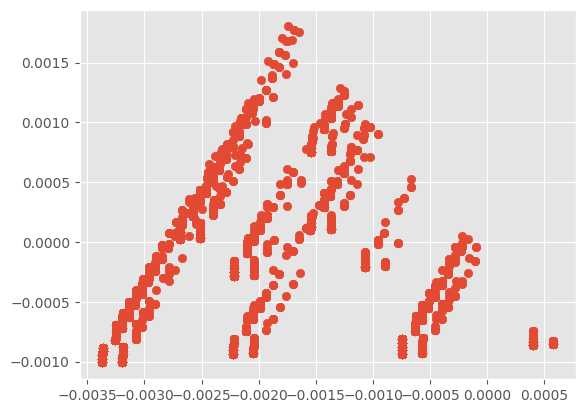

In [47]:
filtered_label0 = X_pca[label == 0]
 
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

Visualize using PCA of 2D

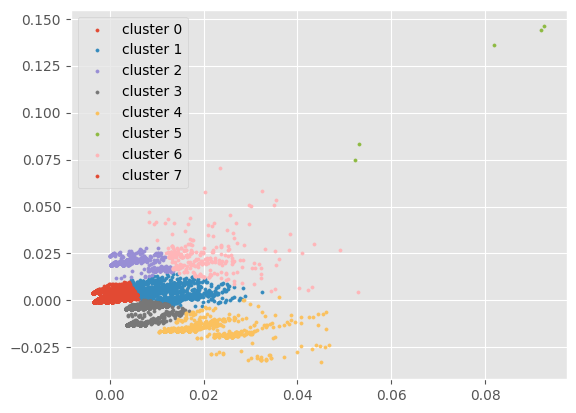

In [48]:
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X_pca[label == i , 0] , X_pca[label == i , 1] , label = "cluster %s" % (i), s=5)
plt.legend()
plt.show()

Plotting the Cluster Centroids

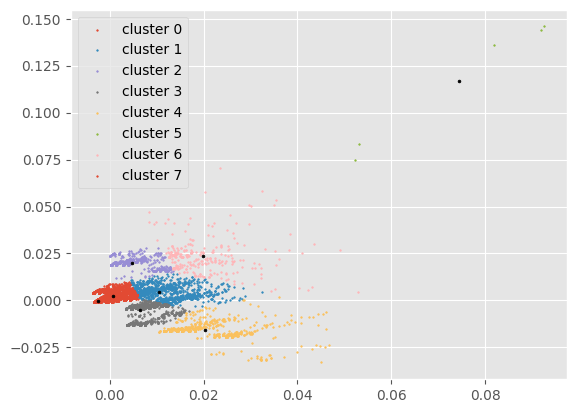

In [49]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results
 
for i in u_labels:
    plt.scatter(X_pca[label == i , 0] , X_pca[label == i , 1] , label = "cluster %s" % (i), s=5, marker='.')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 4, color = 'k')
plt.legend()
#plt.figure(figsize=(100, 100), dpi=300)
plt.show()

PCA to 3D for 3D visualization

In [50]:
pca = PCA(3)
X_pca = pca.fit_transform(X)
X_pca[1 , 0]

-0.0031917790736055835

In [52]:
#Initialize the class object
kmeans = KMeans(n_clusters= 7)
 
#predict the labels of clusters.
label = kmeans.fit_predict(X_pca)
 
unique, counts = np.unique(label, return_counts=True) # get the cluster labels and the # of data points in each cluster
dict(zip(unique, counts))

{0: 37316, 1: 893, 2: 2489, 3: 4625, 4: 829, 5: 3826, 6: 5}

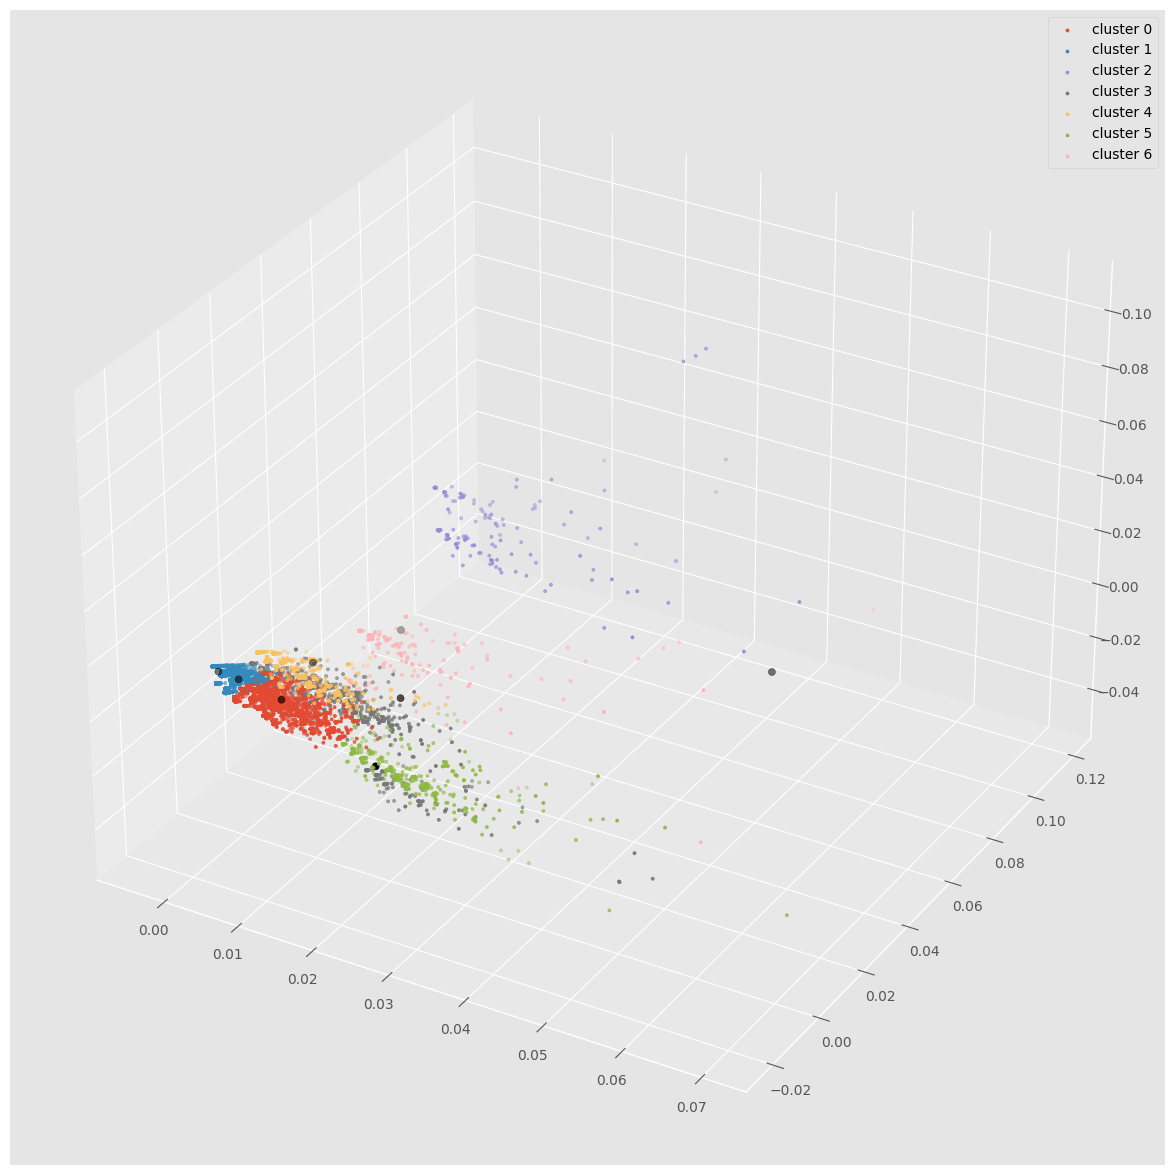

In [104]:
from mpl_toolkits.mplot3d import Axes3D
u_labels = np.unique(label)
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
 
for i in u_labels:
    ax.scatter(X_pca[label == i , 0] , X_pca[label == i , 1] , X_pca[label == i , 2], label = "cluster %s" % (i) , s=5)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 25, color = 'k')
plt.legend()
ax.legend()
plt.show()

Dimensionality Reduction using TSNE

In [ ]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(X)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 19995 samples in 0.003s...
[t-SNE] Computed neighbors for 19995 samples in 3.289s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19995
[t-SNE] Computed conditional probabilities for sample 2000 / 19995
[t-SNE] Computed conditional probabilities for sample 3000 / 19995
[t-SNE] Computed conditional probabilities for sample 4000 / 19995
[t-SNE] Computed conditional probabilities for sample 5000 / 19995
[t-SNE] Computed conditional probabilities for sample 6000 / 19995
[t-SNE] Computed conditional probabilities for sample 7000 / 1999

In [ ]:
X_tsne.shape

(19995, 2)

In [ ]:
#Initialize the class object
kmeans = KMeans(n_clusters= 7)
 
#predict the labels of clusters.
label = kmeans.fit_predict(X_pca)
 
print(label)

[4 0 0 ... 0 0 0]


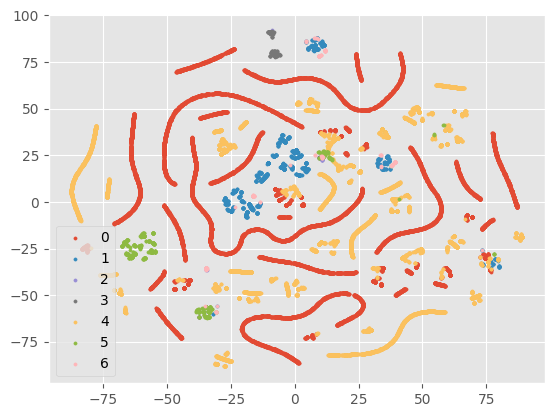

In [ ]:
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X_tsne[label == i , 0] , X_tsne[label == i , 1] , label = i, s=5)
plt.legend()
plt.show()

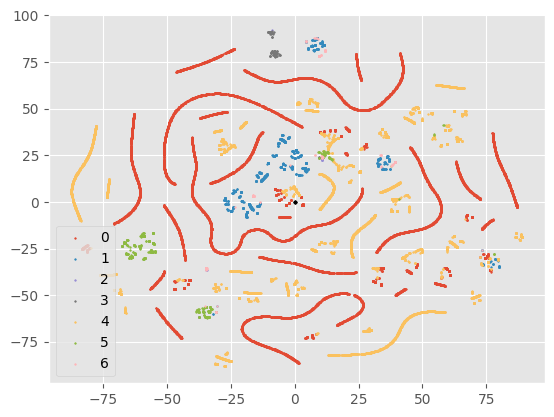

In [ ]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results
 
for i in u_labels:
    plt.scatter(X_tsne[label == i , 0] , X_tsne[label == i , 1] , label = i, s=5, marker='.')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 4, color = 'k')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=17ab9f16-f62d-45b6-ad9d-39c9e2328e27' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>